<a href="https://colab.research.google.com/github/Tepuy-A/Tesis-2/blob/main/GPU_Copia_de_Ising_2D_RNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datos

In [1]:
import requests
import pickle
import numpy as np

url_data = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/Ising2DFM_reSample_L40_T=All.pkl"

# Realiza la solicitud GET al servidor para obtener el contenido del archivo
response_data = requests.get(url_data)
data = pickle.loads(response_data.content, encoding='bytes')
data = np.unpackbits(data).reshape(-1, 1600)
data = data.astype('int')
data[np.where(data == 0)] = -1

url_labels = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/Ising2DFM_reSample_L40_T=All_labels.pkl"

# Realiza la solicitud GET al servidor para obtener el contenido del archivo
response_labels = requests.get(url_labels)
labels = pickle.loads(response_labels.content, encoding='bytes')

In [2]:
# divide data into ordered, critical, and disordered
X_ordered = data[:70000, :]   #Shape (70000, 1600)
Y_ordered = labels[:70000]

X_critical = data[70000:100000, :]  #Shape (30000, 1600)
Y_critical = labels[70000:100000]

X_disordered = data[100000:, :]     #Shape (60000,1600)
Y_disordered = labels[100000:]

In [3]:
from sklearn.model_selection import train_test_split

# define training, critical, and test data sets
X = np.concatenate((X_ordered, X_disordered))    #Shape (130000, 1600)
Y = np.concatenate((Y_ordered, Y_disordered))

# pick random data points from ordered and disordered states to create the training and test sets
X_train_all, X_test, Y_train_all, Y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8)

In [4]:
X_train_all = X_train_all.reshape(-1, 40, 40)  #Shape (104000, 40, 40)
X_test = X_test.reshape(-1,40,40)              #Shape (26000, 40, 40)

In [5]:
X_train_all = np.expand_dims(X_train_all, axis=-1).astype(np.float32)      #Shape (104000, 40, 40, 1)    (#instances, height, width, color channel)
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1)                #Shape (26000, 40, 40, 1)

# Modelo

In [6]:
import tensorflow as tf
from functools import partial

In [7]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=2, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=5, kernel_size=2, input_shape=[40, 40, 1]),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=20*20*5, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=2, activation="softmax")
])

In [8]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train_all, Y_train_all, epochs=10,
                     validation_split=0.2)


score = model.evaluate(X_test, Y_test)

Epoch 1/10
2600/2600 [==============================] - 18s 5ms/step - loss: 0.0098 - accuracy: 0.9990 - val_loss: 5.3778e-07 - val_accuracy: 1.0000
Epoch 2/10
2600/2600 [==============================] - 13s 5ms/step - loss: 2.9130e-08 - accuracy: 1.0000 - val_loss: 2.0347e-07 - val_accuracy: 1.0000
Epoch 3/10
2600/2600 [==============================] - 13s 5ms/step - loss: 1.4732e-08 - accuracy: 1.0000 - val_loss: 9.1127e-08 - val_accuracy: 1.0000
Epoch 4/10
2600/2600 [==============================] - 13s 5ms/step - loss: 4.8956e-09 - accuracy: 1.0000 - val_loss: 1.5897e-08 - val_accuracy: 1.0000
Epoch 5/10
2600/2600 [==============================] - 13s 5ms/step - loss: 1.4127e-09 - accuracy: 1.0000 - val_loss: 6.7684e-09 - val_accuracy: 1.0000
Epoch 6/10
2600/2600 [==============================] - 12s 5ms/step - loss: 5.9175e-10 - accuracy: 1.0000 - val_loss: 3.6335e-09 - val_accuracy: 1.0000
Epoch 7/10
2600/2600 [==============================] - 12s 5ms/step - loss: 2.1779e-1

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


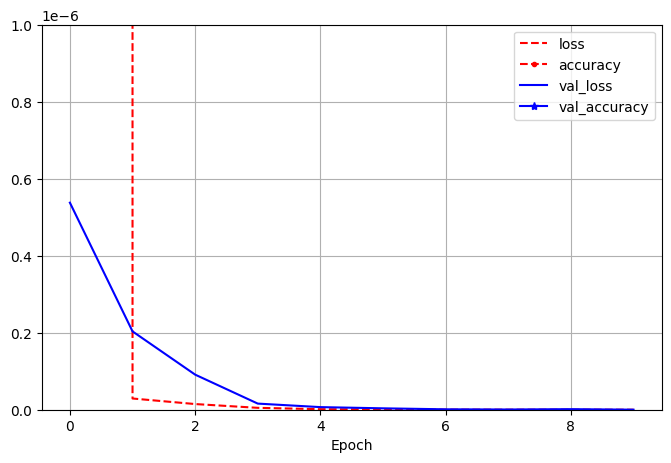

In [13]:
pd.DataFrame(history.history).plot(
 figsize=(8, 5), ylim=[0, 1e-6], grid=True,
xlabel="Epoch",
 style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [14]:
results = pd.DataFrame(history.history)

In [15]:
print(score)

[0.0, 1.0]


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 5)         25        
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 5)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 2000)              4002000   
                                                                 
 dense_1 (Dense)             (None, 2)                 4002      
                                                                 
Total params: 4006027 (15.28 MB)
Trainable params: 4006027 (15.28 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [17]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

In [18]:
X_critical = X_critical.reshape(-1,40,40)              #Shape (30000, 40, 40)

In [19]:
X_critical = np.expand_dims(X_critical.astype(np.float32), axis=-1)                #Shape (30000, 40, 40, 1)

In [20]:
score_critical = model.evaluate(X_critical, Y_critical)

938/938 [==============================] - 3s 3ms/step - loss: 0.9641 - accuracy: 0.8987


Prueba